### VISSIM Trajectory Files: The Contents and Processing Methodology

VISSIM has the capability of posting vehicle trajectory information for all the vehicles in the simulation network at a maximum 10 Hz frequency synchronously with the simulation run. The trajectory data gets stored in readable semicolon-seperated FZP format. The file carries 3D coordinates (both vehicle front and rear), speed, vehicle type, acceleration and headway for all the vehicles which can be comparable to Basic Safety Messages (BSMs). In this article, we show how we use the 20 seconds of sample FZP file and estimate several Key Performance Indices (KPIs) like energy consumption, vehicular emissions, etc. using MOVES matrix. Figure below is a screenshot of the beginning of a typical FZP file generated in VISSIM.

<img src="images/FZP_Snapshot.png">

Trajectory data received at 10 Hz has noise in it to be used for energy-emission estimation directly. To encounter the noise, data is condensed down to 1 Hz by taking every second worth data for each vehicle (i.e. 10 data-points), compute the median speed, acceleration and grade (in a process which we call ***MedianCondensation***). We use the condensed data and put it in MOVES matrix to estimate energy and emissions for every simulation second of each vehicle (in a process we call ***KPI_Estimation***). The following flowchart gives the high level operation of the two processes.

<img src="images/Flowchart.PNG">

The entire process is performed in Python 3.6 on the trajectory data for the first 2 mins from the PM peak hour (i.e. 4PM-5PM) of Jan 14, 2019 on the North Avenue Corridor.

In [1]:
import sqlite3 as lite
import csv 
import statistics as st
import numpy as np 

def getType(length):
    char=['PC','B','SU','TT']
    if(length>10 and length<18):
        return 'PC'
    elif(length>35 and length<45):
        return 'B'
    elif(length>25 and length<35):
        return 'SU'
    elif(length>50 and length<60):
        return 'TT'

def MedianCondensation(infile, db_name, table_name):
	f_m = 0.3048006096012192
	CarList=[]; CarType=[]; CarU=[]; CarV=[]
	CarGrade=[]; CarTime=[]; CarDist=[]
	CarX=[]; CarY=[]; CarZ=[]; CarSpeed=[]; CarAccl=[]
	to_db=[]

	with open(infile) as loglines:
	    for line in loglines:
	        f=line.split('\n')[0].split(';')
	        t=float(f[0]); vN=int(f[2]); VType=getType(float(f[9]))
	        XYZ_f=[float(i) for i in f[3].split()]; XYZ_r=[float(i) for i in f[4].split()]
	        X=XYZ_f[0]; Y=XYZ_f[1]; Z=XYZ_f[2]
	        X_1=XYZ_r[0]; Y_1=XYZ_r[1]; Z_1=XYZ_r[2]
	        speed=float(f[5])*0.44704; accl=float(f[6])*f_m
	        u, v=X - X_1, Y - Y_1
	        uv=(u**2+v**2)**.5
	        u/=uv; v/=uv        

	        if vN not in CarList:
	            CarList.append(vN); CarType.append(VType)
	            CarDist.append(0.0); CarGrade.append(0.0); CarTime.append([t])
	            CarX.append([0.5*(X+X_1)]); CarY.append([0.5*(Y+Y_1)]); CarZ.append([0.5*(Z+Z_1)]); CarSpeed.append([speed]); CarAccl.append([accl])
	            CarU.append([u]); CarV.append([v])
	            j=len(CarList)-1
	        else:
	            j=CarList.index(vN)
	            CarTime[j].append(t)
	            if len(CarX[j])>0:
	                CarDist[j]+=((CarX[j][-1]-X)**2 + (CarY[j][-1]-Y)**2)**.5 
	            CarX[j].append(0.5*(X+X_1)); CarY[j].append(0.5*(Y+Y_1)); CarZ[j].append(0.5*(Z+Z_1)); CarSpeed[j].append(speed); CarAccl[j].append(accl)
	            CarU[j].append(u); CarV[j].append(v)

	        if round(CarTime[j][-1]*10)%10==9:
	            tim=int(np.floor(CarTime[j][0]))
	            X=st.median(CarX[j]); Y=st.median(CarY[j]);  Z=st.median(CarZ[j]); speed=st.median(CarSpeed[j]); accl=st.median(CarAccl[j])
	            tdist=sum(CarSpeed[j])*0.223694; ttime=0.1*len(CarSpeed[j])
	            u=np.mean(CarU[j]); v=np.mean(CarV[j])
	            uv=(u**2+v**2)**.5
	            u/=uv; v/=uv
	            Grade=CarGrade[j] 
	            if CarDist[j]>0.0:
	                Grade=(CarZ[j][-1]-CarZ[j][0])/CarDist[j]
	            CarTime[j]=[]; CarX[j]=[]; CarY[j]=[]; CarZ[j]=[]; CarSpeed[j]=[]; CarAccl[j]=[]; CarDist[j]=0.0; CarGrade[j]=Grade
	            CarU[j]=[]; CarV[j]=[]
	            to_db.append((tim, vN, VType, X, Y, Z, u, v, speed, accl, Grade, tdist, ttime))

	for j in range(len(CarList)):
		if len(CarX[j])>0:
			vN, VType = CarList[j], CarType[j]
			tim=int(np.floor(CarTime[j][0]))
			X=st.median(CarX[j]); Y=st.median(CarY[j]);  Z=st.median(CarZ[j]); speed=st.median(CarSpeed[j]); accl=st.median(CarAccl[j])
			tdist=sum(CarSpeed[j])*0.223694; ttime=0.1*len(CarSpeed[j])
			u=np.mean(CarU[j]); v=np.mean(CarV[j])
			uv=(u**2+v**2)**.5
			u/=uv; v/=uv
			Grade=CarGrade[j]
			if CarDist[j]>0.0:
				Grade=(CarZ[j][-1]-CarZ[j][0])/CarDist[j]
			to_db.append((tim, vN, VType, X, Y, Z, u, v, speed, accl, Grade, tdist, ttime))		

	con = lite.connect(db_name)
	cur = con.cursor()
	cur.executemany("INSERT INTO "+table_name+" VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);", to_db)
	con.commit()
	con.close()      


db_name='./analysis_test/Sample-Condensed-Trajectory.db'
con = lite.connect(db_name)
cur = con.cursor()
cur.execute("CREATE TABLE OneHzData (TSt, VehID, VehType, X, Y, Z, vector_u, vector_v, speed_m_s, accl_m_s_s, grade, Distance_mphs, duration);")
con.commit()    
con.close()

MedianCondensation('./analysis_test/Sample_Trajectory.fzp', db_name, 'OneHzData')

The function reduced the 10 Hz data to data consisting of second-by-second location of all the vehicles in the network during that time listed along with their vehicle ID, type, locations, speed, direction vector and road grade. Here is a screenshot of the resultant 1 Hz Database: 

<img src="images/CondensedData.PNG">

Now we use this condensed trajectory to estimate aforementioned KPIs. Before we do that, we explore how the speed, acceleration, grade data from vehicles are used to estimate energy and emissions using MOVES matrix, which is based on EPA's MOVES model [1]. The process is described in Guenslar et al. (2017).

(1) **Vehicle Specific Power (VSP) Calculation**: We calculate the VSP/STP using the parameters, speed, acceleration, road grade (if available). VSP (or STP) is a function of vehicle mass, dynamics parameters, speed, acceleration, and gravitational acceleration.

<img src="images/VSPCalculation.PNG">

The constanst *A*, *B*, *C*, *M* and *m* are depends on the type of vehicle. For our current exercise, we get the type of vehicle from the vehicle length extracted from the trajectory. Hence, it is clear that all information needed for calculating VSP/ STP are present in the condensed trajectory database.

(2) **VSP Bin using Speed, Acceleration & VSP**: A combination of VSP, speed and acceleration determines the operating mode of the vehicle. Each operating mode corresponds to an ID (VSP bin) which is instrumental to get an estimate of energy consumption or vehicular emission. Here is how the VSP bin is decided.

<img src="images/VSPBins.PNG">

(3) **Use Energy/Emissions Lookup for Estimate**: Based on the VSP bin and the year and classification of the vehicle, we get an estimate of energy/ emission from MOVES. For the current data, we only use four types of vehicles: Passenger Car (PC), Bus (B), Single Unit (SU) and Trailer Truck (TT) and finally for estimates, we use the data last updated in 2017.

As proof of concept, we estimate energy comsumption and carbon dioxide emission for all the vehicles in the condensed trajectory database.

In [2]:
def getBin(speed, accl, VSP):
    if accl<=-2.0:
        return 0
    elif speed<1.0:
        return 1
    elif speed<25:
        if VSP<0:
            return 11
        elif VSP<3:
            return 12
        elif VSP<6:
            return 13
        elif VSP<9:
            return 14
        elif VSP<12:
            return 15
        else:
            return 16
    elif speed<50:
        if VSP<0:
            return 21
        elif VSP<3:
            return 22
        elif VSP<6:
            return 23
        elif VSP<9:
            return 24
        elif VSP<12:
            return 25
        elif VSP<18:
            return 27
        elif VSP<24:
            return 28
        elif VSP<30:
            return 29
        else:
            return 30
    else:
        if VSP<6:
            return 33
        elif VSP<12:
            return 35
        elif VSP<18:
            return 37
        elif VSP<24:
            return 38
        elif VSP<30:
            return 39
        else:
            return 40

def KPI_Estimation(v,acc,VType,grade):
    Energy=[]
    char=['PC','B','SU','TT']
    A=[0.156461,1.03968,0.596526,1.47389]
    B=[0.002001,0,0,0]
    C=[0.000492,0.003587,0.001603,0.003681]
    M=[1.4788,17.1,17.1,17.1]
    m=[1.4788,16.556,8.5389,24.419]
    g=9.81
    j=char.index(VType)
    VSP=(A[j]/M[j])*v+(B[j]/M[j])*v**2+(C[j]/M[j])*v**3+(m[j]/M[j])*(acc+g*grade)*v
    Bin=getBin(v*2.23694,acc*2.23694,VSP)
    BinDetails=list(map(list, zip(*(list(csv.reader(open('./EnergyLookup/EnergyEmissions_'+VType+'_2017.csv')))))))
    for i in range(8):
        Energy.append(float(BinDetails[i+1][BinDetails[0].index(str(Bin))]))
    return Energy


db_name='./analysis_test/Sample-Condensed-Trajectory.db'
con = lite.connect(db_name)
cur = con.cursor()
cur.execute("SELECT * FROM OneHzData;")
data=cur.fetchall()
cur.execute("CREATE TABLE KPIData (TSt, VehID, VehType, X, Y, vector_u, vector_v, Energy_kJ, CO2_gm);")
con.commit()    
con.close()
to_db=[]

for i in data:
	energy=[x*i[12]/3600.0 for x in KPI_Estimation(i[8], i[9], i[2], i[10])]
	to_db.append((i[0], i[1], i[2], i[3], i[4], i[6], i[7], energy[0], energy[1]))

con = lite.connect(db_name)
cur = con.cursor()
cur.executemany("INSERT INTO KPIData VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?);", to_db)
con.commit()    
con.close()

We now have second-by-second energy and emissions for the vehicles in the network stored in the database, applying the ***KPI_Estimation*** function on our condensed trajectory database. Here is a part of the resulting database:

<img src="images/KPIEstimate.PNG">

Different kinds of graphics can be extracted from the ***KPIData*** database table. For example, we can produce a emission trajectory (emission vs distance/time) for individual vehicles. To demonstrate this, we pick vehicle with ID 45044 (at random) and look at its cumulative carbon dioxide emission with time.

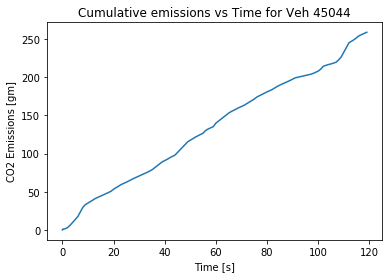

In [4]:
import matplotlib.pyplot as plt

db_name='./analysis_test/Sample-Condensed-Trajectory.db'
con = lite.connect(db_name)
cur = con.cursor()
cur.execute("SELECT TSt, CO2_gm FROM KPIData WHERE VehID=45044;")
data=cur.fetchall()
con.commit()    
con.close()

emdata=[[0], [0.0]]

strt=data[0][0]

for i in data:
    emdata[0].append(i[0]-strt)
    emdata[1].append(emdata[1][-1]+i[1])

plt.plot(emdata[0], emdata[1])
plt.title('Cumulative emissions vs Time for Veh 45044')
plt.xlabel('Time [s]')
plt.ylabel('CO2 Emissions [gm]')
plt.show()

The scope of this is not limited to energy and emissions estimates. Based on the locations and headings of the each vehicle (vector_u: X-direction, vector_v: Y-direction), we get an idea of aggreagte travel time, delays and space-mean-speed of a collection of vehicles if necessary. 

### References

[1] MOVES and Other Mobile Source Emissions Models. https://www.epa.gov/moves. Accessed Feb. 23, 2020.

[2] 29.	Guensler, R., H. Liu, Y. Xu, A. Akanser, D. Kim, M. P. Hunter, and M. O. Rodgers. Energy Consumption and Emissions Modeling of Individual Vehicles. Transportation Research Record: Journal of the Transportation Research Board, Vol. 2627, No. 1, 2017, pp. 93–102.